##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>


In [ ]:
#@title
%%html
<iframe src="https://www.polskacyfrowa.gov.pl/media/48246/FE_POPC_poziom_pl-1_rgb.jpg" width="800"></iframe>


# Uczenie głębokie

Jacek Rumiński, Politechnika Gdańska, Wydział ETI, Katedra Inżynierii Biomedycznej

**Wykład 4:** Architektury sieci splotowych

**Przykład (1):** Problem przeuczenia sieci - "dropout" i "batch normalization"


W ramach tego notatnika zapoznajmy się z aspektami regularyzacji modelu/procesu uczenia z wykorzystaniem operacji logicznej redukcji neuronów (ang. (neuron) dropout) oraz standardyzacji porcji danych (ang. batch normalization).

Wskażmy pakiety, z jakich będziemy korzystać:


In [ ]:
import numpy as np
import datetime, os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set_theme()
from matplotlib.colors import ListedColormap
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

# You can try to change your Google Colab environment to GPU
print(tf.__version__)

# You can always check which packages are installed using:
# !pip list

2.9.2


In [ ]:
# Check if you have GPU resources (Runtime / Change runtime type -> GPU)
!nvidia-smi

Tue Oct 25 13:15:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |   1910MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Check devices using TF
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# remove logs
!ls .
!ls logs
!pwd
!rm -rf logs

logs  sample_data
20221025-130321  20221025-130649
/content


<h2>Dropout - logiczna (i losowa) redukcja neuronów</h2>

W [1] G. Hinton wraz z współpracownikami pokazali znaczenie losowej redukcji neuronów (ang. dropout) na redukcję problemu nadmiernego dopasowania modelu do danych.

W kolejnych epokach losowa wybrana pula neuronów jest eliminowana z prawdopodobieństwem q=1-p (q – dropout rate, p – retain ratio). Zatem można sobie wyobrazić, że w każdej epoce trenowana jest jakby trochę inna architektura modelu. Na koniec eksperymentów mamy efekt uogólnienia różnych modeli dla wejściowego zestawu danych.

Przypomina to trochę efekt podobny jak dla poznanych w czasie wykładu z uczenia maszynowego metod typu bagging (bootstrap aggregation).

W implementacjach praktycznych nie są usuwane neurony, ale ustawiane są losowo wartości 0 na wylosowanych pozycjach tensora wejściowego danej warstwy. Pozostałe wartości tensora wejściowego są normalizowane (skalowane przez wartości s=1/(1-q)).

[1] G. Hinton i inni, 2012, https://arxiv.org/abs/1207.0580


Metodę redukcji neuronów implementuje się jako funkcję w postaci warstwy modelu głębokiego. Przykładowo w TF:

```Python
layer = tf.keras.layers.Dropout(rate=0.2)
```

Zapoznajmy się z prostym przykładem:


In [ ]:
layer_drop = tf.keras.layers.Dropout(rate=0.5, input_shape=(2,))
simple_input_data = np.arange(8).reshape(4, 2).astype(np.float32)+1
print("Simple input data: \n", simple_input_data)

outputs = layer_drop(simple_input_data, training=True)
print("\nResult of the dropout operation: \n", outputs)

Simple input data: 
 [[1. 2.]
 [3. 4.]
 [5. 6.]
 [7. 8.]]

Result of the dropout operation: 
 tf.Tensor(
[[ 2.  0.]
 [ 6.  0.]
 [ 0. 12.]
 [ 0. 16.]], shape=(4, 2), dtype=float32)


Zróbmy eksperyment ponownie z danymi CIFAR-10.

True original label : 6 frog


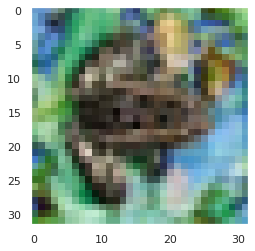

In [ ]:
# Load data and split to training and test datasets

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = [
'airplane','automobile','bird', 'cat', 'deer' ,
'dog', 'frog', 'horse', 'ship', 'truck']

# Data properties
image_width = 32;
image_height = 32;
image_components = 3

# Show an example
example = 200
class_id = y_train[example].item()

plt.rcParams["axes.grid"] = False
plt.imshow(x_train[example])
print("True original label :", class_id, class_names[class_id])


In [ ]:
# Show the shape of input data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("X train dataset shape: ", x_train.shape)
print("Max value in X train: ", np.max(x_train))

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


X train dataset shape:  (50000, 32, 32, 3)
Max value in X train:  255.0


In [ ]:
# Normalize image data
x_train = x_train / 255.0
x_test = x_test / 255.0

# You can try to standsardize images (using mean and std. dev.)

# Set some training parameters
batch_size = 64
epochs = 10
no_of_classes = 10
learning_rate = 0.01

Ponownie wykorzystajmy architekturę podobną do modelu LeNet-5 opublikowany przez Yanna LeCuna i innych w 1998 roku.


In [ ]:
def get_LeNet5_model_w_droput():
  model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=x_train.shape[1:], name="input"),
      tf.keras.layers.Conv2D(6, kernel_size=5, activation='relu',
                              name="c1"),
      tf.keras.layers.AveragePooling2D(pool_size=(2,2), name="s1"),
      tf.keras.layers.Conv2D(16, kernel_size=5, activation='relu',
                              name="c3"),
      tf.keras.layers.AveragePooling2D(pool_size=(2,2), name="s4"),

      ## use this version (2 layers)
      tf.keras.layers.Conv2D(120, kernel_size=5, activation='relu',
                              name="c5"),
      tf.keras.layers.Flatten(),  # make data flat to use dense layers

      # OR this version instead (2 layers)
      # tf.keras.layers.Flatten(),  # make data flat to use dense layers
      # tf.keras.layers.Dense(120, activation = 'relu', name="C5"),

      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(84, activation='relu', name="d6"),
      tf.keras.layers.Dense(no_of_classes, activation='softmax', name="d7")

    ])
  return model

Przygotujmy ustawienia procedury uczenia.

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

In [ ]:
# Use "logs" folder to store data for TensorBoard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
!ls

# Define callback function for TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

sample_data


In [ ]:
def train_model(model, callbacks, opt, epochs=10, batch_size=32, iterations=None):
  """
  Train model - use some global variable (you can modify the definition
                to make this function more univeral)
  model - model to train
  callbacks = list of callback functions
  opt - type of the optimizer
  epochs - number of epochs
  batch_size = sieze of a batch of data
  iterations - set steps_per_epoch
                if None -> equal to the number of samples in your
                dataset divided by the batch size

  """

  model.compile(
    # Choose the optimizer
    optimizer=opt,
    loss='categorical_crossentropy',
    # Introduce additional metric
    metrics=['accuracy']
  )

  model.fit(x=x_train,
            y=y_train,
            epochs=epochs,
            batch_size=batch_size,
            steps_per_epoch=iterations,
            # Use test data to perform validation
            validation_data=(x_test, y_test),
            # Assign reference to the TB callback function
            callbacks=callbacks)

In [ ]:
# Learning rate scheduler
def scheduler(epoch, lr):

  if epoch < 5:
    eta = 0.01
  else:
    eta = lr * tf.math.exp(-0.02)

  if eta < 0.005:
    eta = 0.001

  print("Learning rate is: ", eta)
  return eta

Przeprowadźmy proces uczenia modelu wykorzystującego warstwę Dropout.

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [lr_scheduler,tensorboard_callback]

model_to_train = get_LeNet5_model_w_droput()

# Redefine hiperparameters - use more epoch in the experiments
epochs = 40
# epochs = 5
learning_rate = 0.01
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
# adam = tf.keras.optimizers.Adam(learning_rate=learning_rate*0.1, beta_1=0.9, beta_2=0.999)

# Start training
train_model(model_to_train, callbacks=callbacks, opt=sgd,
            epochs=epochs, batch_size=batch_size)

Learning rate is:  0.01
Epoch 1/40
782/782 [==============================] - 5s 5ms/step - loss: 1.8993 - accuracy: 0.3007 - val_loss: 1.6098 - val_accuracy: 0.4171 - lr: 0.0100
Learning rate is:  0.01
Epoch 2/40
782/782 [==============================] - 4s 5ms/step - loss: 1.5507 - accuracy: 0.4369 - val_loss: 1.4343 - val_accuracy: 0.4826 - lr: 0.0100
Learning rate is:  0.01
Epoch 3/40
782/782 [==============================] - 4s 5ms/step - loss: 1.4309 - accuracy: 0.4868 - val_loss: 1.3370 - val_accuracy: 0.5165 - lr: 0.0100
Learning rate is:  0.01
Epoch 4/40
782/782 [==============================] - 5s 6ms/step - loss: 1.3653 - accuracy: 0.5086 - val_loss: 1.3293 - val_accuracy: 0.5188 - lr: 0.0100
Learning rate is:  0.01
Epoch 5/40
782/782 [==============================] - 7s 9ms/step - loss: 1.3060 - accuracy: 0.5313 - val_loss: 1.2387 - val_accuracy: 0.5519 - lr: 0.0100
Learning rate is:  tf.Tensor(0.009801987, shape=(), dtype=float32)
Epoch 6/40
782/782 [==================

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 394), started 0:11:43 ago. (Use '!kill 394' to kill it.)

<IPython.core.display.Javascript object>

Możemu zauważyć, że zredukowaliśmy problem nadmiernego dopasowania modelu do danych.

<h2>Batch normalization - standardyzacja porcji danych</h2>

BN - standardyzacja danych polega na zastosowaniu funkcji, która:
- standardyzuje porcję danych względem wartości średniej i odchylenia standardowego dla PORCJI danych $\hat{x}$ =(batch-mi(batch))/std_dev(batch)
- poszukuje parametrów $\gamma$ i $\beta$ skalujących uzyskane wartości: $y=\gamma * \hat{x} +\beta $

Standardyzacja porcji danych dla sieci CNN powinna być realizowana po wyjściu modelu liniowego, przez zastosowaniem funkcji aktywacji, tj. operacja
z = a (Wh+b)
jest zamieniana na:
z=a (BN(Wh)).

W praktyce niektóre zespoły wskazują pozytywne wyniki uczenia i inferencji przy stosowaniu BN po funkcji aktywacji. Inni podkreślają, że zależeć to może od rodzaju funkcji aktywacji.

W TensorFlow możemy wykorzystać warstwę (funkcję):
```Python
tf.keras.layers.BatchNormalization()
```

Dodajmy ją do naszego wcześniejszego modelu:

In [ ]:
def get_LeNet5_model_w_BN():

  model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=x_train.shape[1:], name="input"),
      tf.keras.layers.Conv2D(6, kernel_size=5, activation=None, name="c1"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.AveragePooling2D(pool_size=(2,2), name="s1"),

      tf.keras.layers.Conv2D(16, kernel_size=5, activation=None, name="c3"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.AveragePooling2D(pool_size=(2,2), name="s4"),

      ## use this version (2 layers)
      tf.keras.layers.Conv2D(120, kernel_size=5, activation=None, name="c5"),
      tf.keras.layers.ReLU(),

      tf.keras.layers.Flatten(),  # make data flat to use dense layers

      # OR this version instead (2 layers)
      # tf.keras.layers.Flatten(),  # make data flat to use dense layers
      # tf.keras.layers.Dense(120, activation = 'relu', name="C5"),

      # Droput after all BN operations
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(84, activation='relu'),
      tf.keras.layers.Dense(no_of_classes, activation='softmax')

    ])
  return model

I przeprowadźmy trening modelu.

In [ ]:
# Use "logs" folder to store data for TensorBoard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# Define callback function for TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# callbacks = [lr_scheduler,tensorboard_callback]
callbacks = [tensorboard_callback]

model_to_train = get_LeNet5_model_w_BN()

# Redefine hiperparameters - use more epoch in the experiments
epochs = 40
# epochs = 5
learning_rate = 0.01
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
# adam = tf.keras.optimizers.Adam(learning_rate=learning_rate*0.1, beta_1=0.9, beta_2=0.999)

# Start training
# For BN use full batches - to have stable moving mean and var for inference
train_model(model_to_train, callbacks=callbacks, opt=sgd,
            epochs=epochs, batch_size=batch_size,
            iterations=int(x_train.shape[0]/batch_size))

Epoch 1/40
781/781 [==============================] - 5s 6ms/step - loss: 1.5939 - accuracy: 0.4134 - val_loss: 1.5500 - val_accuracy: 0.4547
Epoch 2/40
781/781 [==============================] - 4s 5ms/step - loss: 1.3555 - accuracy: 0.5118 - val_loss: 1.4215 - val_accuracy: 0.4965
Epoch 3/40
781/781 [==============================] - 4s 5ms/step - loss: 1.2552 - accuracy: 0.5494 - val_loss: 1.3604 - val_accuracy: 0.5079
Epoch 4/40
781/781 [==============================] - 4s 5ms/step - loss: 1.1879 - accuracy: 0.5758 - val_loss: 1.2653 - val_accuracy: 0.5507
Epoch 5/40
781/781 [==============================] - 4s 5ms/step - loss: 1.1314 - accuracy: 0.5973 - val_loss: 1.1569 - val_accuracy: 0.5925
Epoch 6/40
781/781 [==============================] - 4s 6ms/step - loss: 1.0917 - accuracy: 0.6106 - val_loss: 1.1545 - val_accuracy: 0.5985
Epoch 7/40
781/781 [==============================] - 4s 5ms/step - loss: 1.0562 - accuracy: 0.6247 - val_loss: 1.1352 - val_accuracy: 0.5986
Epoch 

Możemy zauważyć, że zwykle procesu uczenia modelu z BN wskazuje szybsze uzyskiwanie lepszych wartośc miar jakości.

Własne eksperymenty - jakie kombinacje poznanych dotądoperacji i parametrów dają najlepsze rezultaty dla modelu bazującego na LeNet-5?


<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>